In [1]:
!python -m pip install spiceypy > /dev/null 2>&1

In [3]:
import spiceypy as spy
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
# Download the necessary SPICE files
!wget -q https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls > /dev/null 2>&1
!wget -q https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de435.bsp > /dev/null 2>&1
!wget -q https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/gm_de431.tpc > /dev/null 2>&1

In [6]:
spy.furnsh(["naif0012.tls","de435.bsp","gm_de431.tpc"]) # Load the data into memory

In [11]:
# Convert TC time to dynamic time
et = spy.str2et("2001-04-27 00:00:00 UTC-5")

# Gravitational constant
G = 6.67430e-20  # km^3/kg/s^2

In [9]:
# Body list
bodies = ["Sun", "Mercury Barycenter", "Venus Barycenter", "Earth-Moon Barycenter",
          "Mars Barycenter", "Jupiter Barycenter", "Saturn Barycenter", "Uranus Barycenter", "Neptune Barycenter"]

In [12]:
# Obtain positions, velocities and masses
positions = {}
velocities = {}
masses = {}

for body in bodies:
    state, _ = spy.spkezr(body, et, "ECLIPJ2000", "None", "SSB")
    positions[body] = np.array(state[:3])
    velocities[body] = np.array(state[3:])
    GM = spy.bodvrd(body, "GM", 1)[1][0]
    masses[body] = GM / G

$\textbf{Start Date:}$ April 27, 2001

#1. Total energy of the system formed by the 8 planets and the Sun on Jupiter

To calculate the total energy of the Solar System, we first need the magnitude of the kinetic energy $(K)$ and the gravitational potential energy $(U)$ of each planet. Thus, to calculate the total energies, we have:

$$K_{total} = \sum_{i=1}^{N} \frac{1}{2}m_i v_i^2 $$

$$U_{total} = \sum_{i\neq j}^{N} -\frac{G m_i m_j}{r^3} r_{ij} $$

Where we can finally obtain the total energy by: $$E_{total} = K_{total} + U_{total}$$

In [13]:
# Calculate total kinetic energy
K_total = 0
for body in bodies:
    v = spy.vnorm(velocities[body])
    m = masses[body]
    K_total += 0.5 * m * v**2

In [14]:
# Calculate gravitational potential energy
U_total = 0
for i in range(len(bodies)):
    for j in range(i + 1, len(bodies)):
        b1 = bodies[i]
        b2 = bodies[j]
        m1 = masses[b1]
        m2 = masses[b2]
        r = spy.vdist(positions[b1], positions[b2])
        U_total += -G * m1 * m2 / r

In [16]:
# Total energy in Joules
E_total = (K_total + U_total) * 1e6  # km² → m²

In [17]:
print(f"Total system energy (Sun + 8 planets): {E_total:.3e} J")
print(f"Kinetic energy of Jupiter: {(0.5 * masses['Jupiter Barycenter'] * spy.vnorm(velocities['Jupiter Barycenter'])**2 * 1e6):.3e} J")

Total system energy (Sun + 8 planets): -1.981e+35 J
Kinetic energy of Jupiter: 1.693e+35 J


The total energy of the solar system is negative. We see that both the magnitude of the total energy of the solar system and the magnitude of Jupiter's kinetic energy are on the order of $10^{35}$

#2. Energy in 100 years

The starting date will be $\textbf{April 27, 2001}$ and the ending date will be $\textbf{April 27, 2101}$ at $\textbf{00:00:00 UTC-5}$, taking 1-year intervals.

In [18]:
# Time array: 100 values over 100 years (converted to seconds)
deltat = np.linspace(0, 100, 100) * 365.25 * 86400

In [19]:
# Initialize energy arrays
K_total = []
U_total = []
E_total = []

for dt in deltat:
    # Get state vectors of all 9 bodies at each epoch
    states = {}
    for body in bodies:
        state, _ = spy.spkezr(body, et + dt, "ECLIPJ2000", "None", "SSB")
        states[body] = {
            "r": np.array(state[:3]),
            "v": np.array(state[3:])
        }

    # Compute total kinetic energy
    K = 0
    for body in bodies:
        v = spy.vnorm(states[body]["v"])
        m = masses[body]
        K += 0.5 * m * v**2
    K_total.append(K)

    # Compute total gravitational potential energy (pairwise)
    U = 0
    for i in range(len(bodies)):
        for j in range(i + 1, len(bodies)):
            b1 = bodies[i]
            b2 = bodies[j]
            r = spy.vdist(states[b1]["r"], states[b2]["r"])
            U += -G * masses[b1] * masses[b2] / r
    U_total.append(U)

    # Total energy (converted from km²·kg/s² to J)
    E_total.append((K + U) * 1e6)

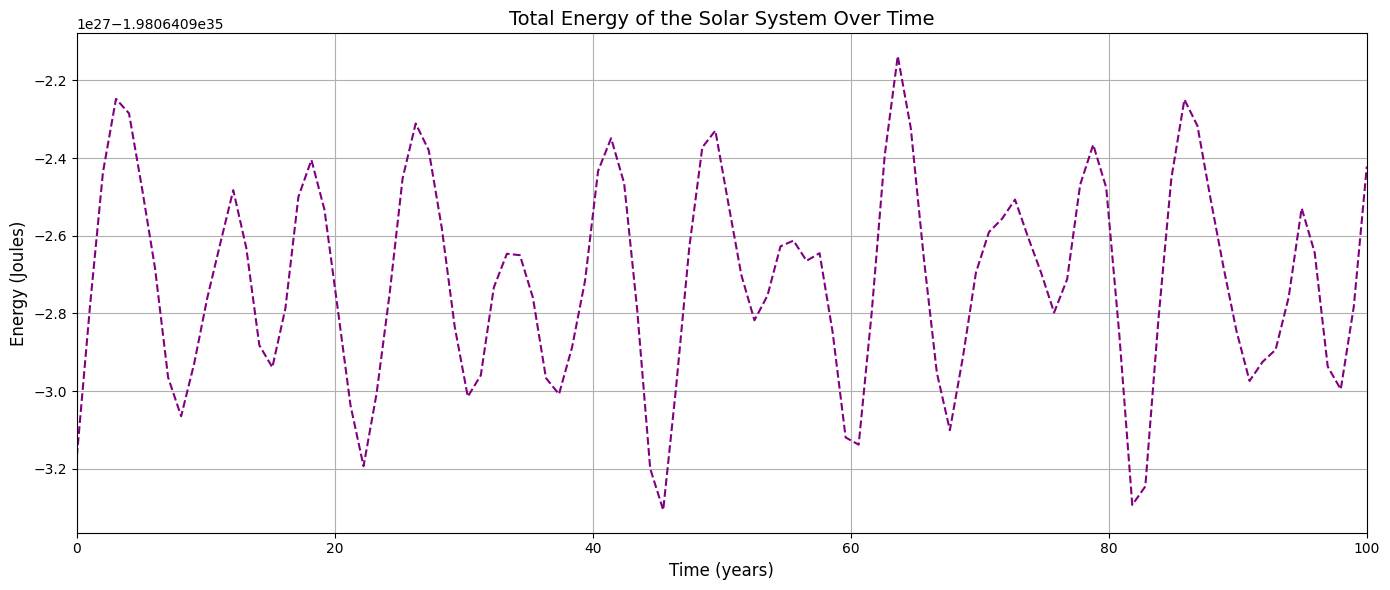

In [20]:
# Plot energy as a function of time
plt.figure(figsize=(14, 6))
plt.plot(deltat / (365.25 * 86400), E_total, '--', color='purple')
plt.title("Total Energy of the Solar System Over Time", fontsize=14)
plt.xlabel("Time (years)", fontsize=12)
plt.ylabel("Energy (Joules)", fontsize=12)
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

From the graph, we can see that over a period of 100 years, the total energy of the Solar System remains within the same order of magnitude ($10^{35}$ J). Therefore, we conclude that the energy is approximately constant.

#3. Total angular momentum of the solar system

To calculate the total angular momentum of the Solar System at the initial date and 100 years later, we will use:

$$ \vec L_{total} = \sum_{i=1}^{N} \vec {r_i}\times\vec{p_i} = \vec{r_i}\times m_i\vec{v_i}$$

Then, to find the angle $θ$ between these two vectors we will use the dot product property given by:

$$\vec A \cdot \vec B = AB cos\theta$$

In [25]:
# Initial date
et_initial = spy.str2et("2001-04-27 00:00:00 UTC-5")

# Retrieve position and velocity vectors of all bodies at initial date
states_initial = {}
for body in bodies:
    state, _ = spy.spkezr(body, et_initial, "ECLIPJ2000", "None", "SSB")
    states_initial[body] = {
        "r": np.array(state[:3]),
        "v": np.array(state[3:])}

# Compute total angular momentum at initial date
L_initial = np.zeros(3)
for body in bodies:
    m = masses[body]
    r = states_initial[body]["r"]
    v = states_initial[body]["v"]
    L_initial += m * np.cross(r, v)

# Final date: 100 years later
et_final = spy.str2et("2101-04-27 00:00:00 UTC-5")

In [26]:
# Retrieve position and velocity vectors at final date
states_final = {}
for body in bodies:
    state, _ = spy.spkezr(body, et_final, "ECLIPJ2000", "None", "SSB")
    states_final[body] = {
        "r": np.array(state[:3]),
        "v": np.array(state[3:])}

In [27]:
# Compute total angular momentum at final date
L_final = np.zeros(3)
for body in bodies:
    m = masses[body]
    r = states_final[body]["r"]
    v = states_final[body]["v"]
    L_final += m * np.cross(r, v)

In [28]:
# Calculate the angle between the two angular momentum vectors
dot_product = np.dot(L_initial, L_final)
norms = spy.vnorm(L_initial) * spy.vnorm(L_final)
angle_rad = math.acos(dot_product / norms)
angle_deg = math.degrees(angle_rad)

In [29]:
print("Total angular momentum of the solar system on April 27, 2001:", L_initial * 1e6, "kg·m²/s")
print("Total angular momentum of the solar system on April 27, 2101:", L_final * 1e6, "kg·m²/s")
print("The angle between the two angular momentum vectors is:", angle_deg, "degrees")


Total angular momentum of the solar system on April 27, 2001: [8.22599478e+41 2.60665295e+41 3.13135003e+43] kg·m²/s
Total angular momentum of the solar system on April 27, 2101: [8.22599475e+41 2.60665339e+41 3.13135004e+43] kg·m²/s
The angle between the two angular momentum vectors is: 0.0 degrees


We must analyze the result of the angular momentum variation over the 100-year period, as the computed angle was exactly $0^\circ$.

This outcome is likely due to the numerical precision limitations of the software during operations such as the dot product $(np.dot())$ used in the calculation.

Nevertheless, we conclude that the change in the total angular momentum vector is extremely small—effectively negligible—which confirms that angular momentum is nearly constant and thus conserved in the Solar System over this time span.

#4. Inclination of the Earth's orbital plane with respect to the Laplace invariable plane of the solar system.

To calculate the angle of inclination of the orbital plane of the Earth and the other planets with respect to the Laplace-invariant plane of the Solar System, we will find the angle between the angular momentum vector of each planet and the total angular momentum vector of the Solar System.

In [30]:
# Recalculate angular momentum vectors at initial date (April 27, 2001)
et = spy.str2et("2001-04-27 00:00:00 UTC-5")
states = {}

In [31]:
for body in bodies:
    state, _ = spy.spkezr(body, et, "ECLIPJ2000", "None", "SSB")
    states[body] = {
        "r": np.array(state[:3]),
        "v": np.array(state[3:])
    }

# Angular momentum vector of each body
angular_momenta = {
    body: masses[body] * np.cross(states[body]["r"], states[body]["v"])
    for body in bodies
}

In [32]:
# Total angular momentum vector of the Solar System
L_total = sum(angular_momenta.values())

# Angular momentum vector of the Earth
L_earth = angular_momenta["Earth-Moon Barycenter"]

# Compute inclination angle between Earth's orbital plane and Laplace plane
dot = np.dot(L_total, L_earth)
angle_rad = math.acos(dot / (spy.vnorm(L_total) * spy.vnorm(L_earth)))
angle_deg = math.degrees(angle_rad)

In [33]:
print("The inclination of Earth's orbital plane relative to the invariable Laplace plane is {:.2f}°".format(angle_deg))

The inclination of Earth's orbital plane relative to the invariable Laplace plane is 1.57°


#5. Inclination of the orbital plane of the planets with respect to the invariable Laplace plane of the solar system.

In [37]:
# Calculate inclination angles of all planets relative to the invariable Laplace plane
planet_inclinations = {}

for body in bodies:
    if body == "Sun":
        continue  # skip the Sun
    L_body = angular_momenta[body]
    angle_rad = math.acos(np.dot(L_total, L_body) / (spy.vnorm(L_total) * spy.vnorm(L_body)))
    angle_deg = math.degrees(angle_rad)
    planet_inclinations[body] = angle_deg

In [39]:
print("Orbital plane inclinations of the planets relative to the invariable Laplace plane:")
for body, angle in planet_inclinations.items():
    name = body.replace(" Barycenter", "")
    print(f"{name}: {angle:.2f}°")

Orbital plane inclinations of the planets relative to the invariable Laplace plane:
Mercury: 6.36°
Venus: 2.19°
Earth-Moon: 1.57°
Mars: 1.67°
Jupiter: 0.33°
Saturn: 0.93°
Uranus: 1.03°
Neptune: 0.73°


In [40]:
max_inclination = max(planet_inclinations.items(), key=lambda x: x[1])
min_inclination = min(planet_inclinations.items(), key=lambda x: x[1])

print(f"\nPlanet with the largest inclination: {max_inclination[0].replace(' Barycenter', '')} ({max_inclination[1]:.2f}°)")
print(f"Planet with the smallest inclination: {min_inclination[0].replace(' Barycenter', '')} ({min_inclination[1]:.2f}°)")


Planet with the largest inclination: Mercury (6.36°)
Planet with the smallest inclination: Jupiter (0.33°)


The planet with the greatest inclination is Mercury with an angle of 6.4°

The planet with the lowest inclination is Jupiter with an angle of 0.33°

Comparing the results obtained with those appearing in the literature, we conclude that the values ​​of the angles found are correct.